# NSFW Analysis - Consumer Notebook

This notebook consumes NSFW analysis results from the NATS endpoint and processes them.

In [1]:
import os
import json
import asyncio
import uuid
from pathlib import Path
from datetime import datetime

import nats
from nats.js.api import StreamConfig, ConsumerConfig, AckPolicy, RetentionPolicy, DiscardPolicy
from dotenv import load_dotenv
from IPython.display import display, JSON, Image as IPImage
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Load environment variables from .env file
load_dotenv(os.path.join("keys", ".env_file"))

# NATS connection settings
NAT_URL = os.getenv("NAT_URL", "nats://localhost:4222")

# Get NSFW stream and subject settings
OUTPUT_STREAM = os.getenv("OUTPUT_STREAM", "NSFW-RESULTS")
OUTPUT_SUBJECT = os.getenv("OUTPUT_SUBJECT", "nsfw.results.completed.>")

LOCAL_ENV = os.getenv("LOCAL_ENV", "1")

# Create output directories for results
OUTPUT_DIR = "nsfw_results"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Display current configuration
print("NATS NSFW Consumer Configuration:")
print(f"NATS URL: {NAT_URL}")
print(f"NSFW Results Stream: {OUTPUT_STREAM}")
print(f"NSFW Results Subject: {OUTPUT_SUBJECT}")
print(f"Local Environment: {LOCAL_ENV}")
print(f"Output Directory: {OUTPUT_DIR}")

NATS NSFW Consumer Configuration:
NATS URL: nats://localhost:4222
NSFW Results Stream: NSFW-RESULTS
NSFW Results Subject: nsfw.results.completed.>
Local Environment: 1
Output Directory: nsfw_results


## Helper Functions for Analysis

In [3]:
def analyze_nsfw_results(data):
    """
    Analyze NSFW processing results from a single result
    
    Args:
        data: The result data to analyze
    """
    if not data:
        print("No data to analyze")
        return
    
    # Check if data contains nsfw_results
    if "nsfw_results" not in data:
        print("Invalid data format - no NSFW results found")
        return
    
    # Extract file information
    file_name = data.get("file_name", "unknown")
    file_type = data.get("file_type", "unknown")
    threshold = data.get("threshold", 0.5)
    
    print(f"File: {file_name} (Type: {file_type}, Threshold: {threshold})")
    
    # Extract and display NSFW results
    nsfw_results = data["nsfw_results"]
    
    if isinstance(nsfw_results, list) and len(nsfw_results) > 0:
        for i, result in enumerate(nsfw_results):
            print(f"\nResult {i+1}:")
            
            # Check if it's a video result (multiple frames) or image result
            if "nsfw" in result:
                # Image result
                nsfw_flag = result["nsfw"]
                print(f"NSFW Classification: {'NSFW' if nsfw_flag == 1 else 'SFW'}")
                
                # Check if we have class probabilities
                if "class_probabilities" in result:
                    probs = result["class_probabilities"]
                    print("\nClass Probabilities:")
                    for cls, prob in probs.items():
                        print(f"  - {cls}: {prob:.4f}")
                    
                    # Calculate total NSFW probability
                    nsfw_prob = probs.get("sexy", 0) + probs.get("hentai", 0) + probs.get("porn", 0)
                    print(f"\nTotal NSFW Probability: {nsfw_prob:.4f} (Threshold: {threshold})")
            elif "prediction" in result:
                # Video result or simplified format
                score = result.get("prediction", 0)
                nsfw_flag = result.get("nsfw", 0) 
                description = result.get("description", "")
                
                print(f"NSFW Classification: {'NSFW' if nsfw_flag == 1 else 'SFW'}")
                print(f"Score: {score:.4f} (Threshold: {threshold})")
                if description:
                    print(f"Description: {description}")
    else:
        print("No NSFW analysis results found")

In [4]:
def visualize_nsfw_results(data):
    """
    Visualize NSFW analysis results with a bar chart
    
    Args:
        data: The result data to visualize
    """
    if not data or "nsfw_results" not in data:
        print("No data to visualize")
        return
    
    nsfw_results = data["nsfw_results"]
    
    if not nsfw_results or not isinstance(nsfw_results, list) or len(nsfw_results) == 0:
        print("No NSFW results to visualize")
        return
    
    # Check if we have class probabilities (image analysis)
    if "class_probabilities" in nsfw_results[0]:
        # Extract class probabilities for visualization
        probs = nsfw_results[0]["class_probabilities"]
        
        # Create bar chart
        labels = list(probs.keys())
        values = [probs[label] for label in labels]
        
        # Calculate combined NSFW probability for special highlight
        nsfw_classes = ["sexy", "hentai", "porn"]
        nsfw_indices = [i for i, label in enumerate(labels) if label in nsfw_classes]
        
        # Create colors, highlighting NSFW classes in red
        colors = ['#1f77b4' if i not in nsfw_indices else '#d62728' for i in range(len(labels))]
        
        plt.figure(figsize=(10, 6))
        bars = plt.bar(labels, values, color=colors)
        plt.xlabel('Classes')
        plt.ylabel('Probability')
        plt.title('NSFW Class Probabilities')
        plt.ylim(0, 1.0)
        
        # Add value labels on top of bars
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                     f'{height:.3f}', ha='center', va='bottom')
        
        # Add horizontal line for threshold
        threshold = data.get("threshold", 0.5)
        if threshold is not None:
            plt.axhline(y=threshold, color='r', linestyle='--', alpha=0.3)
            plt.text(0, threshold + 0.03, f'Threshold: {threshold}', color='r')
        
        plt.tight_layout()
        plt.show()
        
        # Also show aggregated NSFW probability
        nsfw_prob = sum(probs.get(cls, 0) for cls in nsfw_classes)
        sfw_prob = 1 - nsfw_prob  # Simplified assumption
        
        plt.figure(figsize=(8, 5))
        plt.bar(['SFW', 'NSFW'], [sfw_prob, nsfw_prob], 
                color=['#1f77b4', '#d62728'])
        plt.xlabel('Classification')
        plt.ylabel('Probability')
        plt.title('SFW vs. NSFW Probability')
        plt.ylim(0, 1.0)
        
        # Add value labels
        plt.text(0, sfw_prob + 0.02, f'{sfw_prob:.3f}', ha='center')
        plt.text(1, nsfw_prob + 0.02, f'{nsfw_prob:.3f}', ha='center')
        
        # Add threshold line
        if threshold is not None:
            plt.axhline(y=threshold, color='r', linestyle='--', alpha=0.3)
            plt.text(0, threshold + 0.03, f'Threshold: {threshold}', color='r')
        
        plt.tight_layout()
        plt.show()
        
    elif "prediction" in nsfw_results[0]:
        # Video result or simplified format
        # For videos, we might have multiple frames with predictions
        if len(nsfw_results) > 1:
            # Multiple frames
            scores = [result.get("prediction", 0) for result in nsfw_results]
            
            plt.figure(figsize=(12, 6))
            plt.plot(scores, '-o', color='#1f77b4')
            plt.xlabel('Frame')
            plt.ylabel('NSFW Score')
            plt.title('NSFW Scores Across Video Frames')
            plt.ylim(0, 1.0)
            
            # Add threshold line
            threshold = data.get("threshold", 0.5)
            if threshold is not None:
                plt.axhline(y=threshold, color='r', linestyle='--', alpha=0.6)
                plt.text(0, threshold + 0.03, f'Threshold: {threshold}', color='r')
            
            # Mark frames that exceed threshold
            for i, score in enumerate(scores):
                if score > threshold:
                    plt.plot(i, score, 'ro', markersize=8)
            
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
            
            # Show summary statistics
            avg_score = sum(scores) / len(scores)
            max_score = max(scores)
            nsfw_frames = sum(1 for s in scores if s > threshold)
            nsfw_percentage = (nsfw_frames / len(scores)) * 100
            
            print(f"\nVideo Summary Statistics:")
            print(f"Total Frames Analyzed: {len(scores)}")
            print(f"Average NSFW Score: {avg_score:.4f}")
            print(f"Maximum NSFW Score: {max_score:.4f}")
            print(f"NSFW Frames: {nsfw_frames} ({nsfw_percentage:.1f}%)")
            
            # Show histogram of scores
            plt.figure(figsize=(10, 5))
            plt.hist(scores, bins=20, color='#1f77b4', alpha=0.7)
            plt.xlabel('NSFW Score')
            plt.ylabel('Number of Frames')
            plt.title('Distribution of NSFW Scores Across Video Frames')
            
            # Add threshold line
            if threshold is not None:
                plt.axvline(x=threshold, color='r', linestyle='--', alpha=0.6)
                plt.text(threshold + 0.02, plt.ylim()[1] * 0.9, 
                         f'Threshold: {threshold}', color='r')
            
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
        else:
            # Single result
            score = nsfw_results[0].get("prediction", 0)
            threshold = data.get("threshold", 0.5)
            
            plt.figure(figsize=(8, 5))
            plt.bar(['Score'], [score], color='#1f77b4' if score <= threshold else '#d62728')
            plt.xlabel('NSFW Analysis')
            plt.ylabel('Score')
            plt.title('NSFW Analysis Result')
            plt.ylim(0, 1.0)
            
            # Add value label
            plt.text(0, score + 0.02, f'{score:.3f}', ha='center')
            
            # Add threshold line
            if threshold is not None:
                plt.axhline(y=threshold, color='r', linestyle='--', alpha=0.3)
                plt.text(0, threshold + 0.03, f'Threshold: {threshold}', color='r')
            
            plt.tight_layout()
            plt.show()

## NATS Monitoring and Processing Functions

In [5]:
async def setup_stream(js, stream_name, subjects):
    """
    Ensure a NATS stream exists with the given configuration
    
    Args:
        js: JetStream context
        stream_name: Name of the stream
        subjects: List of subject patterns for the stream
    """
    try:
        # Check if stream already exists
        stream_info = await js.stream_info(stream_name)
        print(f"Stream '{stream_name}' already exists with {stream_info.state.messages} messages")
    except Exception:
        # Create the stream
        stream_config = StreamConfig(
            name=stream_name,
            subjects=subjects,
            retention=RetentionPolicy.LIMITS,
            max_age=30 * 24 * 60 * 60,  # 30 days
            duplicate_window=120,  # 2 minutes
            discard=DiscardPolicy.OLD
        )
        await js.add_stream(config=stream_config)
        print(f"Created stream '{stream_name}' with subjects: {subjects}")

In [6]:
async def monitor_nsfw_results(
    output_dir=OUTPUT_DIR,
    nats_url=NAT_URL,
    stream_name=OUTPUT_STREAM,
    subject=OUTPUT_SUBJECT,
    run_time_seconds=3600,  # Default to run for 1 hour
    poll_interval=1,  # Seconds between polling the stream
    visualize=True  # Whether to visualize results
):
    """
    Monitor a NATS stream for new NSFW results.
    
    Args:
        output_dir: Directory to save output files
        nats_url: The NATS server URL
        stream_name: The stream name to read from
        subject: The subject to monitor
        run_time_seconds: How long to run the consumer (in seconds)
        poll_interval: Seconds between polling the stream
        visualize: Whether to visualize the results
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Connect to NATS
    nc = await nats.connect(nats_url)
    js = nc.jetstream()
    
    # Ensure the stream exists
    await setup_stream(js, stream_name, [subject])
    
    # Track number of messages processed
    messages_processed = 0
    
    # Initialize start_time
    start_time = datetime.now()
    
    try:
        # Get stream info to find the current last sequence
        try:
            stream_info = await js.stream_info(stream_name)
            last_seq = stream_info.state.last_seq
            print(f"Connected to stream '{stream_name}'")
            print(f"Stream contains {stream_info.state.messages} messages")
            print(f"Last sequence is {last_seq}")
        except Exception as e:
            print(f"Error getting stream info: {e}")
            return messages_processed
        
        print(f"Stream monitor will run for {run_time_seconds} seconds or until interrupted")
        print(f"Results will be saved to {output_dir}")
        print("Monitoring for new NSFW analysis results...")
        
        # Current sequence to start from
        current_seq = last_seq + 1
        
        # Poll the stream until the run time is reached
        while (datetime.now() - start_time).total_seconds() < run_time_seconds:
            try:
                # Get the current stream info
                stream_info = await js.stream_info(stream_name)
                new_last_seq = stream_info.state.last_seq
                
                # Check if there are new messages
                if new_last_seq >= current_seq:
                    print(f"Found {new_last_seq - current_seq + 1} new messages")
                    
                    # Get messages from current_seq to new_last_seq
                    for seq in range(current_seq, new_last_seq + 1):
                        try:
                            # Get the message at this sequence
                            msg = await js.get_msg(stream_name, seq)
                            
                            # Check if message subject matches our pattern
                            if not msg.subject.startswith(subject.rstrip(">")):
                                print(f"Skipping message with subject {msg.subject}")
                                continue
                            
                            # Parse message data
                            data = json.loads(msg.data.decode("utf-8"))
                            
                            # Extract file info from headers if available
                            file_info = ""
                            if hasattr(msg, 'headers') and msg.headers:
                                if "filename" in msg.headers:
                                    file_info = msg.headers["filename"]
                                elif "file_name" in msg.headers:
                                    file_info = msg.headers["file_name"]
                            
                            # Generate a filename for the result
                            if file_info:
                                filename = f"nsfw_result_{file_info}.json"
                            else:
                                # Use data from message or generate a timestamp
                                if "file_name" in data:
                                    file_info = data["file_name"]
                                    filename = f"nsfw_result_{file_info}.json"
                                else:
                                    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
                                    filename = f"nsfw_result_{timestamp}_{seq}.json"
                            
                            # Save result to file
                            output_path = os.path.join(output_dir, filename)
                            with open(output_path, "w") as f:
                                json.dump(data, f, indent=2)
                            
                            # Increment counter and display info
                            messages_processed += 1
                            print(f"\nReceived NSFW result #{messages_processed}, seq={seq}, saved to {output_path}")
                            
                            # Analyze the results
                            print("\nNSFW Analysis:")
                            analyze_nsfw_results(data)
                            
                            # Visualize results if requested
                            if visualize:
                                print("\nVisualizing NSFW results:")
                                visualize_nsfw_results(data)
                            
                            print("-" * 50)
                            
                        except Exception as e:
                            print(f"Error processing message with seq={seq}: {str(e)}")
                            continue
                    
                    # Update current_seq
                    current_seq = new_last_seq + 1
                else:
                    # No new messages
                    print("No new messages found. Waiting...")
                
                # Wait before polling again
                await asyncio.sleep(poll_interval)
                
            except Exception as e:
                print(f"Error polling stream: {str(e)}")
                await asyncio.sleep(poll_interval)
                
    except KeyboardInterrupt:
        print("\nReceived interrupt signal, shutting down...")
    except Exception as e:
        print(f"Error in monitor: {str(e)}")
    finally:
        # Close NATS connection
        await nc.close()
        print("NATS connection closed")
    
    # Print summary
    run_time = (datetime.now() - start_time).total_seconds()
    print(f"\nMonitor summary:")
    print(f"- Run time: {run_time:.2f} seconds")
    print(f"- Messages processed: {messages_processed}")
    print(f"- Results saved to: {output_dir}")
    
    return messages_processed

In [7]:
async def process_existing_results(
    output_dir=OUTPUT_DIR,
    nats_url=NAT_URL,
    stream_name=OUTPUT_STREAM,
    subject=OUTPUT_SUBJECT,
    limit=100,  # Maximum number of messages to process
    visualize=True  # Whether to visualize results
):
    """
    Process existing NSFW results in a stream (historical data).
    
    Args:
        output_dir: Directory to save output files
        nats_url: The NATS server URL
        stream_name: The stream name to read from
        subject: The subject to filter by
        limit: Maximum number of messages to process
        visualize: Whether to visualize the results
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Connect to NATS
    nc = await nats.connect(nats_url)
    js = nc.jetstream()
    
    # Ensure the stream exists
    await setup_stream(js, stream_name, [subject])
    
    # Track number of messages processed
    messages_processed = 0
    
    try:
        # Get stream info
        try:
            stream_info = await js.stream_info(stream_name)
            total_messages = stream_info.state.messages
            first_seq = stream_info.state.first_seq
            last_seq = stream_info.state.last_seq
            
            print(f"Connected to stream '{stream_name}'")
            print(f"Stream contains {total_messages} messages")
            print(f"Sequence range: {first_seq} to {last_seq}")
            print(f"Will process up to {limit} most recent messages")
        except Exception as e:
            print(f"Error getting stream info: {e}")
            return messages_processed
        
        # If no messages, return early
        if total_messages == 0:
            print("Stream is empty. No messages to process.")
            return 0
        
        # Determine range of sequences to process (most recent first)
        start_seq = max(first_seq, last_seq - limit + 1)
        
        print(f"Processing messages from sequence {start_seq} to {last_seq}...")
        
        # Process messages in reverse order (newest first)
        for seq in range(last_seq, start_seq - 1, -1):
            try:
                # Get the message at this sequence
                msg = await js.get_msg(stream_name, seq)
                
                # Check if message subject matches our pattern
                if not msg.subject.startswith(subject.rstrip(">")):
                    print(f"Skipping message with subject {msg.subject}")
                    continue
                
                # Parse message data
                data = json.loads(msg.data.decode("utf-8"))
                
                # Extract file info from headers if available
                file_info = ""
                if hasattr(msg, 'headers') and msg.headers:
                    if "filename" in msg.headers:
                        file_info = msg.headers["filename"]
                    elif "file_name" in msg.headers:
                        file_info = msg.headers["file_name"]
                
                # Generate a filename for the result
                if file_info:
                    filename = f"nsfw_result_{file_info}.json"
                else:
                    # Use data from message or generate a timestamp
                    if "file_name" in data:
                        file_info = data["file_name"]
                        filename = f"nsfw_result_{file_info}.json"
                    else:
                        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
                        filename = f"nsfw_result_{timestamp}_{seq}.json"
                
                # Save result to file
                output_path = os.path.join(output_dir, filename)
                with open(output_path, "w") as f:
                    json.dump(data, f, indent=2)
                
                # Increment counter and display info
                messages_processed += 1
                print(f"\nProcessed NSFW result #{messages_processed}, seq={seq}, saved to {output_path}")
                
                # Analyze the results
                print("\nNSFW Analysis:")
                analyze_nsfw_results(data)
                
                # Visualize results if requested
                if visualize:
                    print("\nVisualizing NSFW results:")
                    visualize_nsfw_results(data)
                
                print("-" * 50)
                
            except Exception as e:
                print(f"Error processing message with seq={seq}: {str(e)}")
                continue
                
    except Exception as e:
        print(f"Error in processor: {str(e)}")
    finally:
        # Close NATS connection
        await nc.close()
        print("NATS connection closed")
    
    # Print summary
    print(f"\nProcessor summary:")
    print(f"- Messages processed: {messages_processed}")
    print(f"- Results saved to: {output_dir}")
    
    return messages_processed

In [8]:
async def process_and_monitor_results(
    output_dir=OUTPUT_DIR,
    nats_url=NAT_URL,
    stream_name=OUTPUT_STREAM,
    subject=OUTPUT_SUBJECT,
    run_time_seconds=3600,  # Default to run for 1 hour
    poll_interval=1,  # Seconds between polling the stream
    process_existing=True,  # Whether to process existing messages
    limit_existing=10,  # Limit for existing messages
    visualize=True  # Whether to visualize results
):
    """
    Process existing results and then monitor for new ones.
    
    Args:
        output_dir: Directory to save output files
        nats_url: The NATS server URL
        stream_name: The stream name to read from
        subject: The subject to monitor
        run_time_seconds: How long to run the consumer (in seconds)
        poll_interval: Seconds between polling the stream
        process_existing: Whether to process existing messages
        limit_existing: Maximum number of existing messages to process
        visualize: Whether to visualize the results
    """
    # Process existing messages if requested
    if process_existing:
        print("Processing existing NSFW analysis results...")
        existing_count = await process_existing_results(
            output_dir=output_dir,
            nats_url=nats_url,
            stream_name=stream_name,
            subject=subject,
            limit=limit_existing,
            visualize=visualize
        )
        print(f"Processed {existing_count} existing NSFW analysis results")
    
    # Now monitor for new messages
    print("\nMonitoring for new NSFW analysis results...")
    new_count = await monitor_nsfw_results(
        output_dir=output_dir,
        nats_url=nats_url,
        stream_name=stream_name,
        subject=subject,
        run_time_seconds=run_time_seconds,
        poll_interval=poll_interval,
        visualize=visualize
    )
    
    # Total count
    total_count = (existing_count if process_existing else 0) + new_count
    print(f"\nTotal NSFW analysis results processed: {total_count}")
    
    return total_count

## Process NSFW Analysis Results

Processing existing NSFW analysis results...
Stream 'NSFW-RESULTS' already exists with 2 messages
Connected to stream 'NSFW-RESULTS'
Stream contains 2 messages
Sequence range: 1 to 2
Will process up to 10 most recent messages
Processing messages from sequence 1 to 2...

Processed NSFW result #1, seq=2, saved to nsfw_results/nsfw_result_drawing2.jpg.json

NSFW Analysis:
File: drawing2.jpg (Type: jpg, Threshold: 0.5)

Result 1:
NSFW Classification: SFW

Class Probabilities:
  - drawings: 0.9852
  - hentai: 0.0061
  - neutral: 0.0057
  - porn: 0.0012
  - sexy: 0.0018

Total NSFW Probability: 0.0092 (Threshold: 0.5)

Visualizing NSFW results:


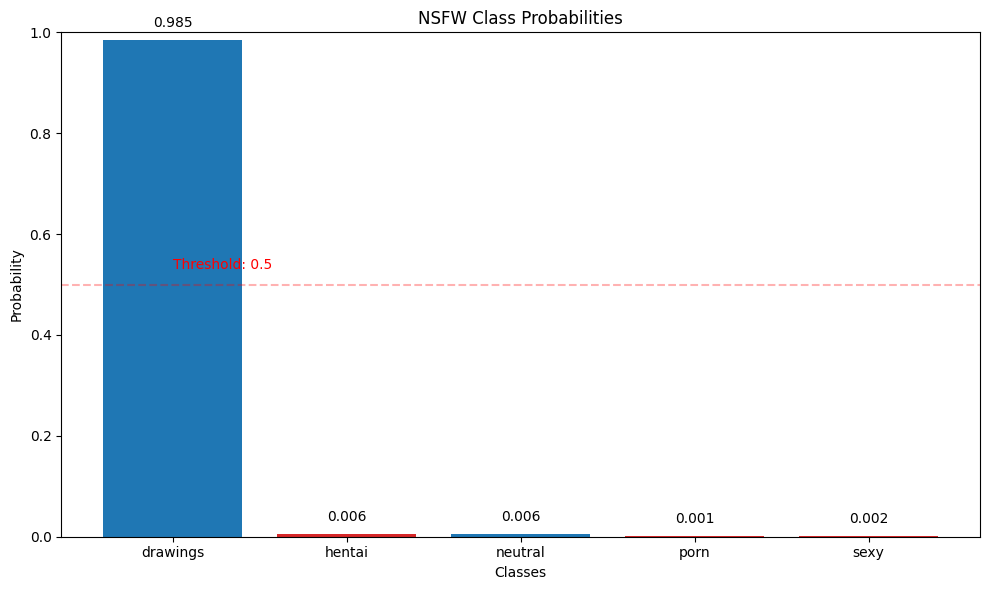

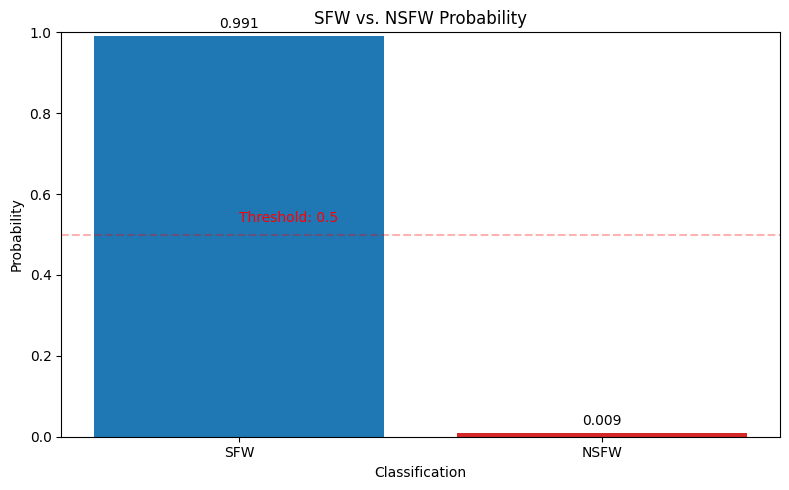

--------------------------------------------------

Processed NSFW result #2, seq=1, saved to nsfw_results/nsfw_result_drawing1.jpg.json

NSFW Analysis:
File: drawing1.jpg (Type: jpg, Threshold: 0.5)

Result 1:
NSFW Classification: SFW

Class Probabilities:
  - drawings: 0.9824
  - hentai: 0.0111
  - neutral: 0.0038
  - porn: 0.0011
  - sexy: 0.0016

Total NSFW Probability: 0.0138 (Threshold: 0.5)

Visualizing NSFW results:


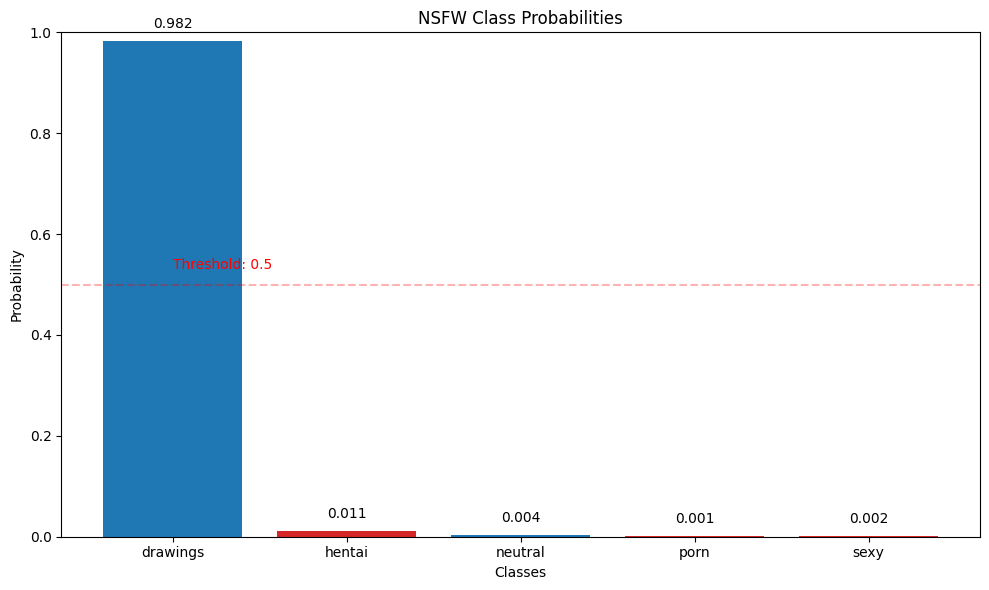

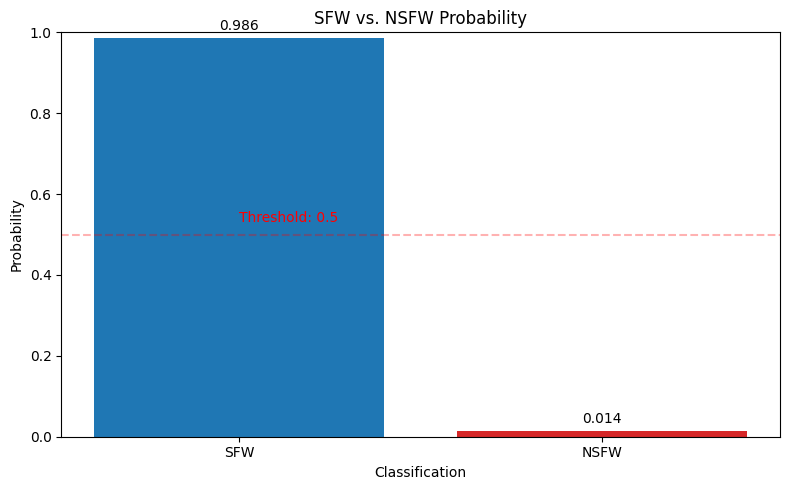

--------------------------------------------------
NATS connection closed

Processor summary:
- Messages processed: 2
- Results saved to: nsfw_results
Processed 2 existing NSFW analysis results

Monitoring for new NSFW analysis results...
Stream 'NSFW-RESULTS' already exists with 2 messages
Connected to stream 'NSFW-RESULTS'
Stream contains 2 messages
Last sequence is 2
Stream monitor will run for 3600 seconds or until interrupted
Results will be saved to nsfw_results
Monitoring for new NSFW analysis results...
No new messages found. Waiting...
No new messages found. Waiting...
No new messages found. Waiting...
No new messages found. Waiting...
No new messages found. Waiting...
No new messages found. Waiting...
No new messages found. Waiting...
No new messages found. Waiting...
No new messages found. Waiting...
No new messages found. Waiting...
No new messages found. Waiting...
No new messages found. Waiting...
No new messages found. Waiting...
No new messages found. Waiting...
No new 

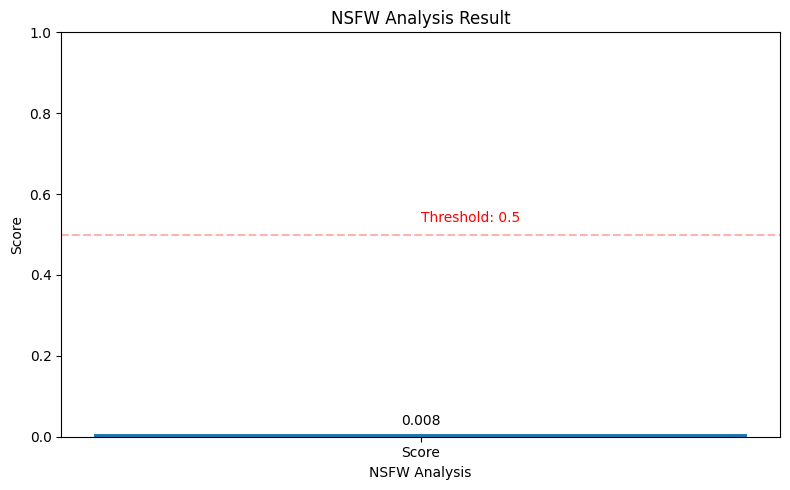

--------------------------------------------------

Received NSFW result #2, seq=4, saved to nsfw_results/nsfw_result_hen1.jpg.json

NSFW Analysis:
File: hen1.jpg (Type: jpg, Threshold: 0.5)

Result 1:
NSFW Classification: NSFW

Class Probabilities:
  - drawings: 0.0036
  - hentai: 0.9869
  - neutral: 0.0046
  - porn: 0.0021
  - sexy: 0.0027

Total NSFW Probability: 0.9918 (Threshold: 0.5)

Visualizing NSFW results:


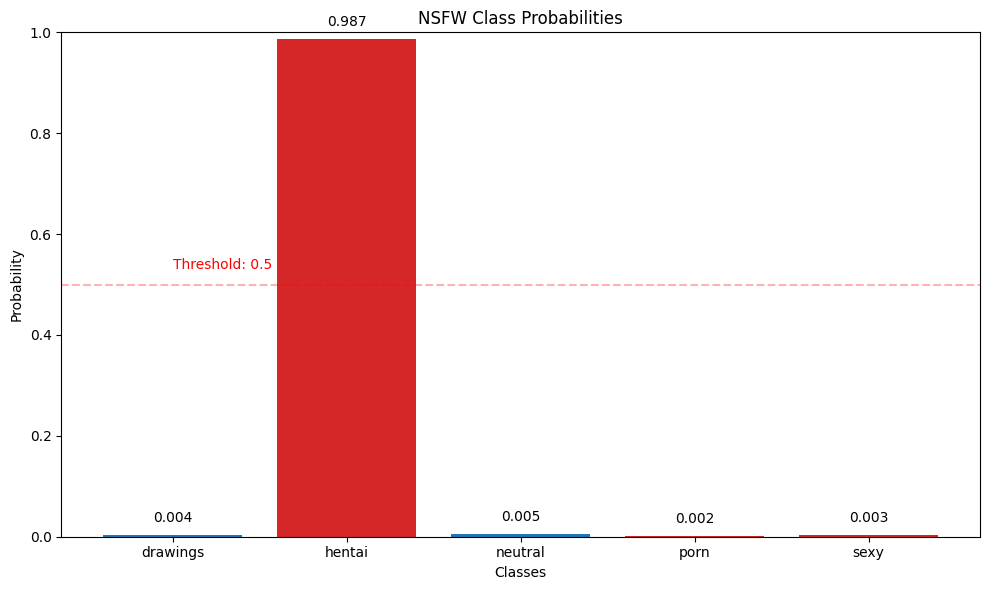

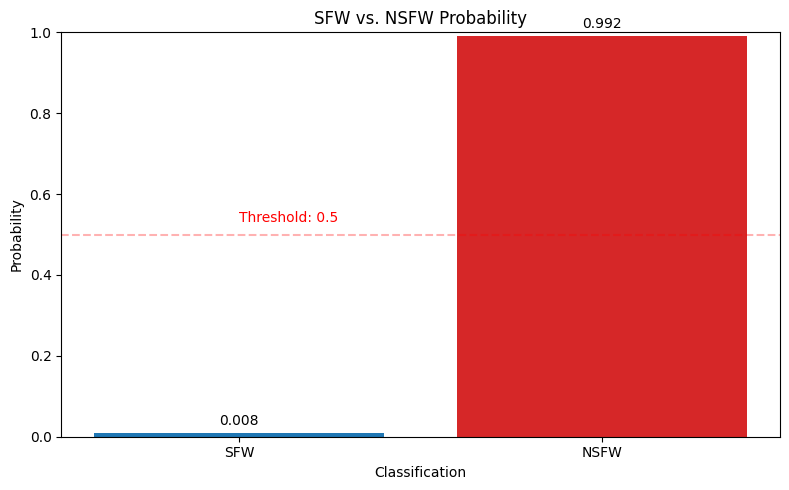

--------------------------------------------------

Received NSFW result #3, seq=5, saved to nsfw_results/nsfw_result_hen2.jpg.json

NSFW Analysis:
File: hen2.jpg (Type: jpg, Threshold: 0.5)

Result 1:
NSFW Classification: SFW

Class Probabilities:
  - drawings: 0.7160
  - hentai: 0.2773
  - neutral: 0.0034
  - porn: 0.0015
  - sexy: 0.0018

Total NSFW Probability: 0.2806 (Threshold: 0.5)

Visualizing NSFW results:


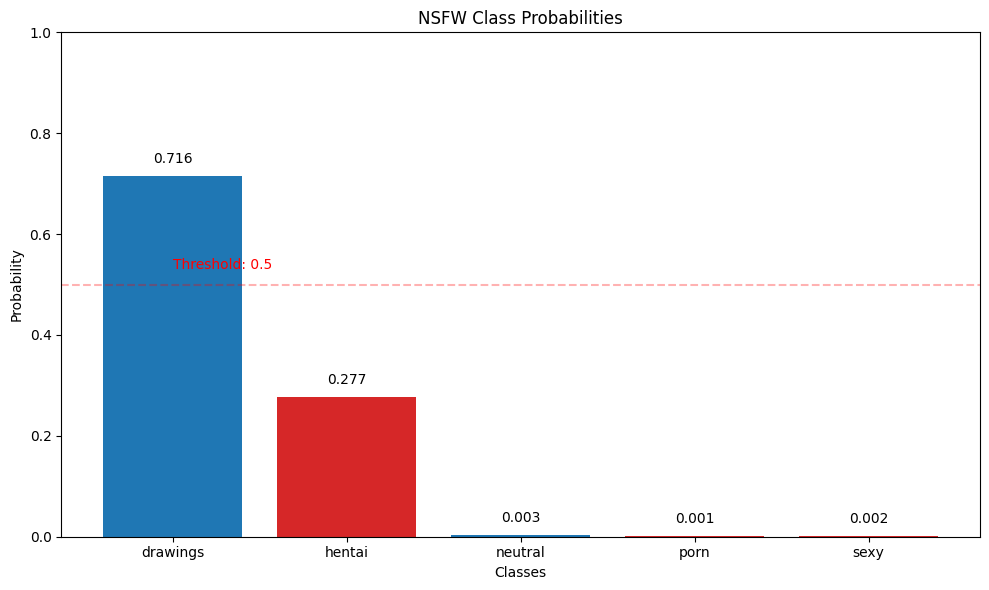

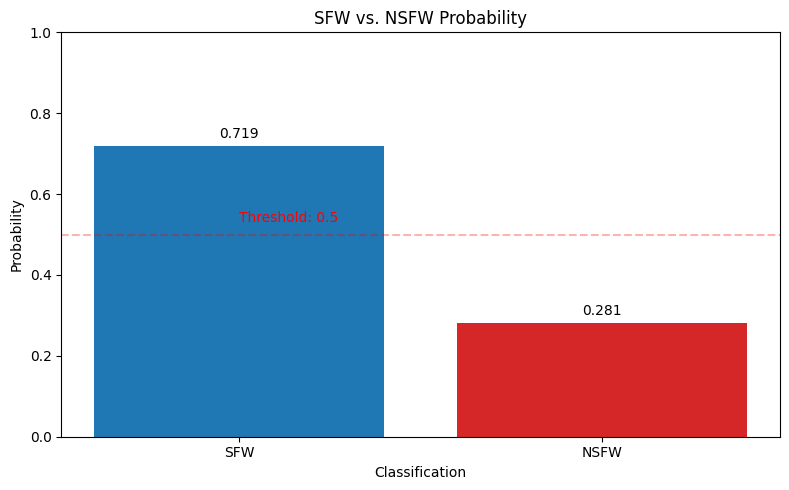

--------------------------------------------------
Found 4 new messages

Received NSFW result #4, seq=6, saved to nsfw_results/nsfw_result_n1.jpg.json

NSFW Analysis:
File: n1.jpg (Type: jpg, Threshold: 0.5)

Result 1:
NSFW Classification: SFW

Class Probabilities:
  - drawings: 0.3673
  - hentai: 0.0087
  - neutral: 0.6194
  - porn: 0.0014
  - sexy: 0.0031

Total NSFW Probability: 0.0133 (Threshold: 0.5)

Visualizing NSFW results:


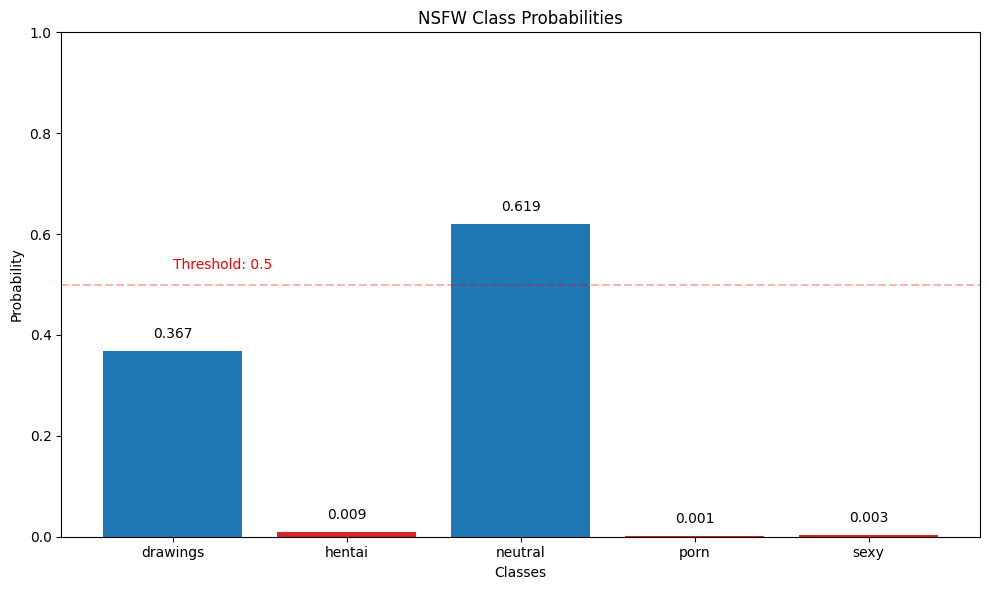

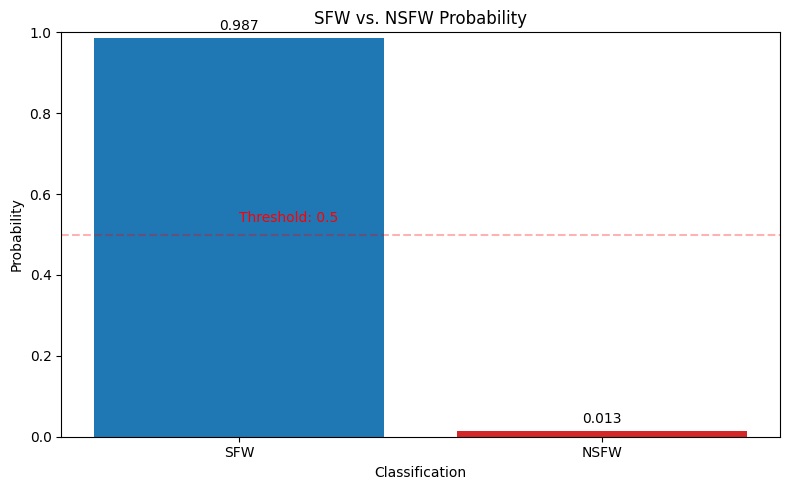

--------------------------------------------------

Received NSFW result #5, seq=7, saved to nsfw_results/nsfw_result_n2.jpg.json

NSFW Analysis:
File: n2.jpg (Type: jpg, Threshold: 0.5)

Result 1:
NSFW Classification: SFW

Class Probabilities:
  - drawings: 0.0143
  - hentai: 0.0027
  - neutral: 0.9792
  - porn: 0.0013
  - sexy: 0.0025

Total NSFW Probability: 0.0065 (Threshold: 0.5)

Visualizing NSFW results:


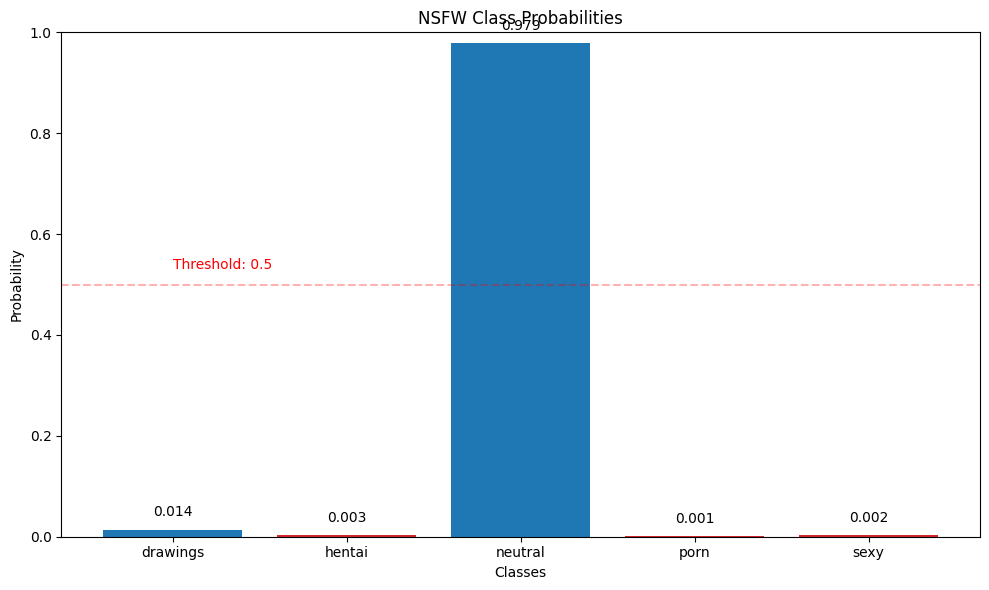

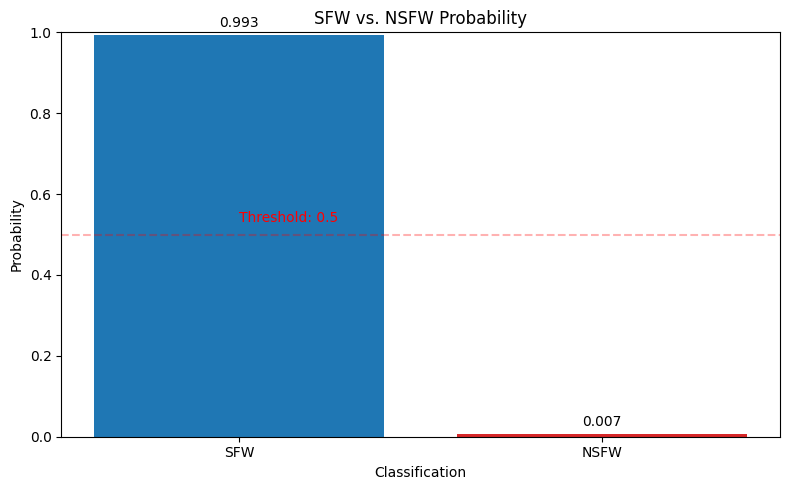

--------------------------------------------------

Received NSFW result #6, seq=8, saved to nsfw_results/nsfw_result_p1.jpg.json

NSFW Analysis:
File: p1.jpg (Type: jpg, Threshold: 0.5)

Result 1:
NSFW Classification: NSFW

Class Probabilities:
  - drawings: 0.0005
  - hentai: 0.0028
  - neutral: 0.0008
  - porn: 0.9929
  - sexy: 0.0030

Total NSFW Probability: 0.9986 (Threshold: 0.5)

Visualizing NSFW results:


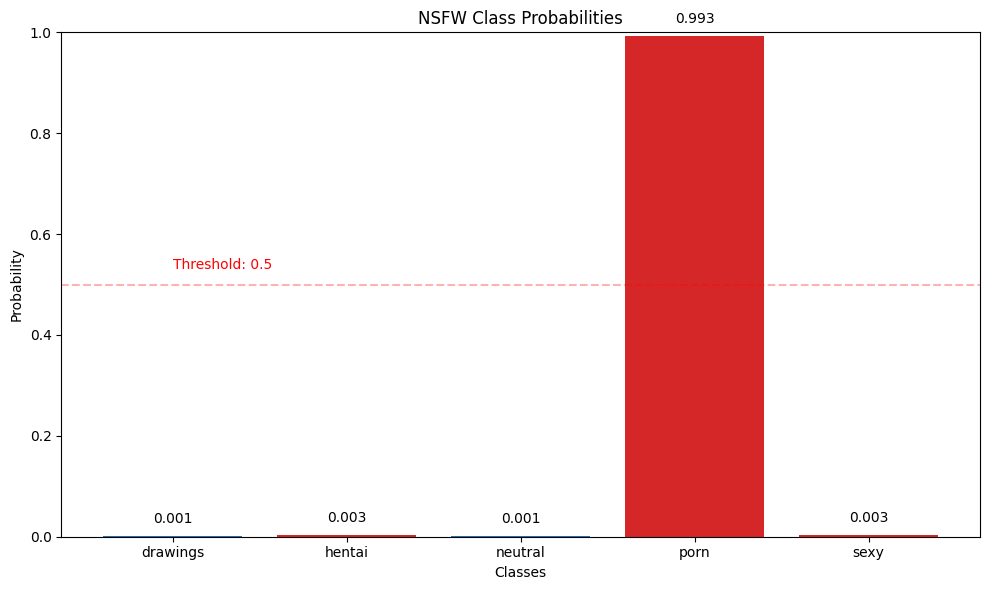

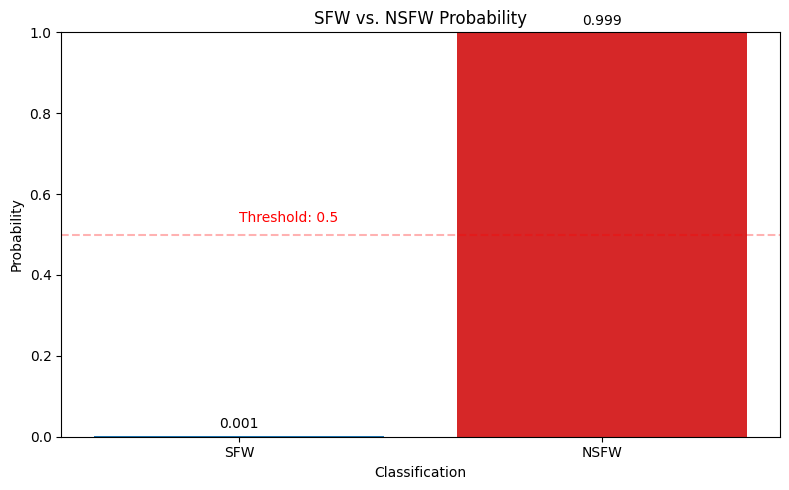

--------------------------------------------------

Received NSFW result #7, seq=9, saved to nsfw_results/nsfw_result_p2.jpg.json

NSFW Analysis:
File: p2.jpg (Type: jpg, Threshold: 0.5)

Result 1:
NSFW Classification: NSFW

Class Probabilities:
  - drawings: 0.0011
  - hentai: 0.0065
  - neutral: 0.0007
  - porn: 0.9791
  - sexy: 0.0126

Total NSFW Probability: 0.9982 (Threshold: 0.5)

Visualizing NSFW results:


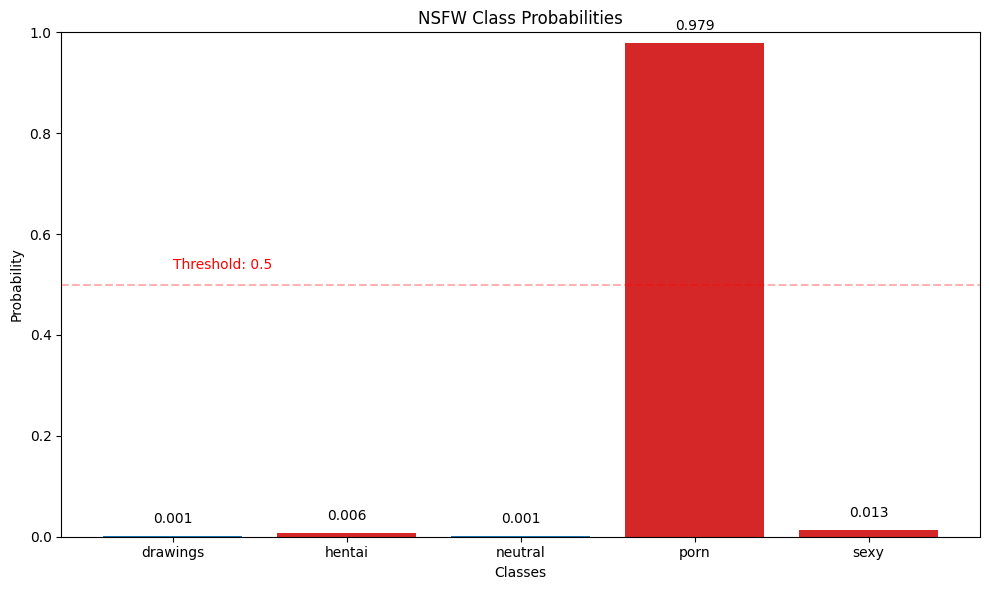

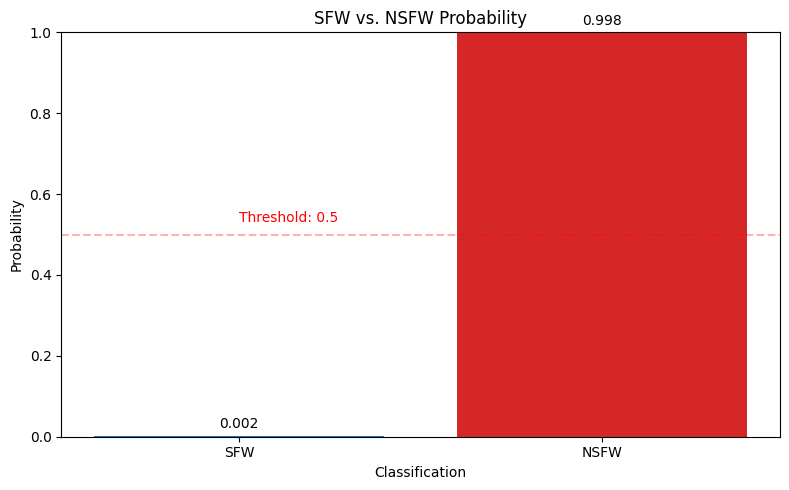

--------------------------------------------------
No new messages found. Waiting...
No new messages found. Waiting...
No new messages found. Waiting...
No new messages found. Waiting...
No new messages found. Waiting...
No new messages found. Waiting...
No new messages found. Waiting...
No new messages found. Waiting...
No new messages found. Waiting...
No new messages found. Waiting...
No new messages found. Waiting...
No new messages found. Waiting...
No new messages found. Waiting...
No new messages found. Waiting...
No new messages found. Waiting...
No new messages found. Waiting...
No new messages found. Waiting...
No new messages found. Waiting...
No new messages found. Waiting...
No new messages found. Waiting...
No new messages found. Waiting...
No new messages found. Waiting...
No new messages found. Waiting...
No new messages found. Waiting...
No new messages found. Waiting...
No new messages found. Waiting...
No new messages found. Waiting...
No new messages found. Waiting.

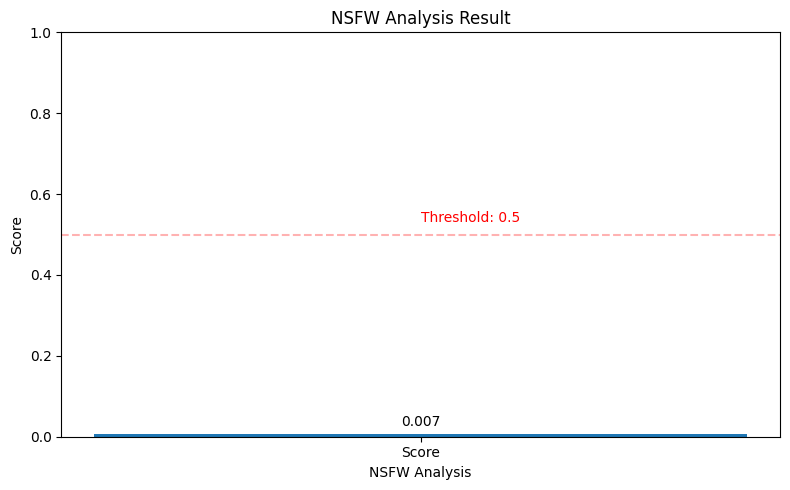

--------------------------------------------------
No new messages found. Waiting...
No new messages found. Waiting...
No new messages found. Waiting...
No new messages found. Waiting...
No new messages found. Waiting...
No new messages found. Waiting...
No new messages found. Waiting...
No new messages found. Waiting...
No new messages found. Waiting...
No new messages found. Waiting...
No new messages found. Waiting...
No new messages found. Waiting...
No new messages found. Waiting...
No new messages found. Waiting...
No new messages found. Waiting...
No new messages found. Waiting...
No new messages found. Waiting...
No new messages found. Waiting...
No new messages found. Waiting...
No new messages found. Waiting...
No new messages found. Waiting...
No new messages found. Waiting...
No new messages found. Waiting...
No new messages found. Waiting...
No new messages found. Waiting...
No new messages found. Waiting...
No new messages found. Waiting...
No new messages found. Waiting.

CancelledError: 

In [9]:
# Choose one option:

# Option 1: Only monitor for new results
# await monitor_nsfw_results(run_time_seconds=3600)

# Option 2: Process existing results (up to 20) but don't monitor for new ones
# await process_existing_results(limit=20)

# Option 3: Process existing results and then monitor for new ones (recommended)
await process_and_monitor_results(
    run_time_seconds=3600,  # 1 hour
    process_existing=True,
    limit_existing=10,      # Process up to 10 existing results
    visualize=True          # Create visualizations for the results
)

## Analyze Saved Results

In [ ]:
def load_and_analyze_saved_results(results_dir=OUTPUT_DIR, limit=None, visualize=True):
    """
    Load and analyze NSFW results saved to disk
    
    Args:
        results_dir: Directory containing saved JSON results
        limit: Maximum number of files to analyze (None for all)
        visualize: Whether to create visualizations
    """
    if not os.path.exists(results_dir):
        print(f"Results directory not found: {results_dir}")
        return
    
    # Get all JSON files in the directory
    json_files = [f for f in os.listdir(results_dir) if f.endswith('.json')]
    
    if not json_files:
        print(f"No JSON result files found in {results_dir}")
        return
    
    # Sort by modification time (newest first)
    json_files.sort(key=lambda f: os.path.getmtime(os.path.join(results_dir, f)), reverse=True)
    
    # Apply limit if specified
    if limit:
        json_files = json_files[:limit]
        
    print(f"Found {len(json_files)} result files in {results_dir}")
    print(f"Analyzing {len(json_files)} files...")
    
    # Process each file
    for i, filename in enumerate(json_files):
        file_path = os.path.join(results_dir, filename)
        print(f"\n{'-' * 50}")
        print(f"Result {i+1}/{len(json_files)}: {filename}")
        
        try:
            with open(file_path, 'r') as f:
                data = json.load(f)
            
            # Analyze the results
            print("\nNSFW Analysis:")
            analyze_nsfw_results(data)
            
            # Visualize results if requested
            if visualize:
                print("\nVisualizing NSFW results:")
                visualize_nsfw_results(data)
                
        except Exception as e:
            print(f"Error processing file {filename}: {str(e)}")
            continue
    
    print(f"\nCompleted analysis of {len(json_files)} result files.")

In [ ]:
# Analyze previously saved results (if any)
# load_and_analyze_saved_results(limit=5)

## Aggregate Analysis of All Results

In [ ]:
def aggregate_nsfw_results(results_dir=OUTPUT_DIR):
    """
    Analyze all NSFW results in the directory and generate aggregate statistics
    
    Args:
        results_dir: Directory containing saved JSON results
    """
    if not os.path.exists(results_dir):
        print(f"Results directory not found: {results_dir}")
        return
    
    # Get all JSON files in the directory
    json_files = [f for f in os.listdir(results_dir) if f.endswith('.json')]
    
    if not json_files:
        print(f"No JSON result files found in {results_dir}")
        return
    
    print(f"Found {len(json_files)} result files in {results_dir}")
    print("Generating aggregate statistics...")
    
    # Statistics to collect
    total_files = 0
    nsfw_files = 0
    images_count = 0
    videos_count = 0
    nsfw_images = 0
    nsfw_videos = 0
    
    # Collect probabilities
    all_scores = []
    image_class_probs = {'drawings': [], 'hentai': [], 'neutral': [], 'porn': [], 'sexy': []}
    
    # Process all files
    for filename in json_files:
        file_path = os.path.join(results_dir, filename)
        
        try:
            with open(file_path, 'r') as f:
                data = json.load(f)
            
            if "nsfw_results" not in data:
                continue
                
            total_files += 1
            file_type = data.get("file_type", "")
            
            # Determine if file is image or video based on file_type or analysis
            is_video = False
            if file_type and file_type.lower() in ['mp4', 'avi', 'mov', 'mkv', 'wmv', 'flv', 'webm']:
                is_video = True
                videos_count += 1
            else:
                images_count += 1
                
            # Extract NSFW results
            nsfw_results = data["nsfw_results"]
            
            if not nsfw_results or not isinstance(nsfw_results, list) or len(nsfw_results) == 0:
                continue
                
            # Check if it's NSFW
            is_nsfw = False
            
            # Check different result formats
            if "nsfw" in nsfw_results[0]:
                # Image result
                nsfw_flag = nsfw_results[0]["nsfw"]
                is_nsfw = (nsfw_flag == 1)
                
                # Check if we have class probabilities
                if "class_probabilities" in nsfw_results[0]:
                    probs = nsfw_results[0]["class_probabilities"]
                    for cls in image_class_probs.keys():
                        if cls in probs:
                            image_class_probs[cls].append(probs[cls])
                    
                    # Calculate total NSFW probability and add to all_scores
                    nsfw_prob = probs.get("sexy", 0) + probs.get("hentai", 0) + probs.get("porn", 0)
                    all_scores.append(nsfw_prob)
            
            elif "prediction" in nsfw_results[0]:
                # Video result or simplified format
                score = nsfw_results[0].get("prediction", 0)
                nsfw_flag = nsfw_results[0].get("nsfw", 0)
                
                is_nsfw = (nsfw_flag == 1)
                all_scores.append(score)
            
            # Update counts
            if is_nsfw:
                nsfw_files += 1
                if is_video:
                    nsfw_videos += 1
                else:
                    nsfw_images += 1
                    
        except Exception as e:
            print(f"Error processing file {filename}: {str(e)}")
            continue
    
    # Generate statistics
    print(f"\nNSFW Analysis Summary:")
    print(f"Total files analyzed: {total_files}")
    print(f"NSFW files detected: {nsfw_files} ({(nsfw_files / total_files * 100) if total_files > 0 else 0:.1f}%)")
    print(f"\nBy file type:")
    print(f"Images: {images_count} total, {nsfw_images} NSFW ({(nsfw_images / images_count * 100) if images_count > 0 else 0:.1f}%)")
    print(f"Videos: {videos_count} total, {nsfw_videos} NSFW ({(nsfw_videos / videos_count * 100) if videos_count > 0 else 0:.1f}%)")
    
    # Create visualizations
    if all_scores:
        plt.figure(figsize=(10, 6))
        plt.hist(all_scores, bins=20, color='#1f77b4', alpha=0.7)
        plt.xlabel('NSFW Score')
        plt.ylabel('Number of Files')
        plt.title('Distribution of NSFW Scores Across All Files')
        plt.axvline(x=0.5, color='r', linestyle='--', alpha=0.6)
        plt.text(0.52, plt.ylim()[1] * 0.9, 'Default Threshold: 0.5', color='r')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    # Visualize class probabilities for images
    if any(len(probs) > 0 for probs in image_class_probs.values()):
        # Calculate average probability for each class
        avg_probs = {}
        for cls, probs in image_class_probs.items():
            if probs:
                avg_probs[cls] = sum(probs) / len(probs)
            else:
                avg_probs[cls] = 0
        
        # Create bar chart
        plt.figure(figsize=(10, 6))
        labels = list(avg_probs.keys())
        values = [avg_probs[label] for label in labels]
        
        # Calculate combined NSFW probability for special highlight
        nsfw_classes = ["sexy", "hentai", "porn"]
        nsfw_indices = [i for i, label in enumerate(labels) if label in nsfw_classes]
        
        # Create colors, highlighting NSFW classes in red
        colors = ['#1f77b4' if i not in nsfw_indices else '#d62728' for i in range(len(labels))]
        
        bars = plt.bar(labels, values, color=colors)
        plt.xlabel('Classes')
        plt.ylabel('Average Probability')
        plt.title('Average NSFW Class Probabilities Across All Images')
        plt.ylim(0, 1.0)
        
        # Add value labels on top of bars
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                     f'{height:.3f}', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()
        
        # Show NSFW vs SFW breakdown
        nsfw_avg = sum(avg_probs.get(cls, 0) for cls in nsfw_classes)
        sfw_avg = 1 - nsfw_avg  # Simplified assumption
        
        plt.figure(figsize=(8, 5))
        plt.bar(['SFW', 'NSFW'], [sfw_avg, nsfw_avg], 
                color=['#1f77b4', '#d62728'])
        plt.xlabel('Classification')
        plt.ylabel('Average Probability')
        plt.title('Average SFW vs. NSFW Probability Across All Images')
        plt.ylim(0, 1.0)
        
        # Add value labels
        plt.text(0, sfw_avg + 0.02, f'{sfw_avg:.3f}', ha='center')
        plt.text(1, nsfw_avg + 0.02, f'{nsfw_avg:.3f}', ha='center')
        
        plt.tight_layout()
        plt.show()

In [ ]:
# Aggregate analysis of all saved results
# aggregate_nsfw_results()